# Accessing Data from the MAAP

Authors: Samuel Ayers (UAH), Brian Satorius (JPL)

Date: May 26, 2022 (Revised July 2023)

Description: In this example, we demonstrate how to access data from the MAAP using the 'getData' method of the maap-py library. At this time, this procedure is the same for user-contributed data added to the store.

## Run This Notebook

To access and run this tutorial within MAAP's Algorithm Development Environment (ADE), please refer to the "Getting started with the MAAP" section of our documentation.

Disclaimer: it is highly recommended to run a tutorial within MAAP's ADE, which already includes packages specific to MAAP, such as maap-py. Running the tutorial outside of the MAAP ADE may lead to errors.

## Additional Resources
- [Search Granules Tutorial](https://docs.maap-project.org/en/latest/technical_tutorials/search/granules.html)
- [Additional Search Attributes](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#g-additional-attribute)

## Importing Packages

We import the `os` module, import the `MAAP` package, and create a new MAAP class.

In [1]:
# import os module
import os

# import the MAAP package
from maap.maap import MAAP

# create MAAP class
maap = MAAP()

For this example, the additional bounding_box attribute is used to search for granules within the Mondah Forest Gabon research site spatial area. For more information about searching for granules in MAAP, please see https://docs.maap-project.org/en/latest/technical_tutorials/search/granules.html.

In [2]:
SHORTNAME = "AFLVIS2"
BBOX = '9.316216,0.538705,9.422509,0.616939'

# search for granules with SHORTNAME
results = maap.searchGranule(
    short_name=SHORTNAME,
    bounding_box=BBOX
)
results[0]

{'concept-id': 'G1549416185-NSIDC_ECS',
 'collection-concept-id': 'C1549378743-NSIDC_ECS',
 'revision-id': '2',
 'format': 'application/echo10+xml',
 'Granule': {'GranuleUR': 'SC:AFLVIS2.001:138348928',
  'InsertTime': '2018-09-24T11:01:33.892Z',
  'LastUpdate': '2018-09-24T11:02:09.869Z',
  'Collection': {'DataSetId': 'AfriSAR LVIS L2 Geolocated Surface Elevation Product V001'},
  'DataGranule': {'SizeMBDataGranule': '130.082',
   'ProducerGranuleId': 'LVIS2_Gabon2016_0304_R1808_054746.TXT',
   'DayNightFlag': 'UNSPECIFIED',
   'ProductionDateTime': '2018-08-23T18:32:04.000Z',
   'LocalVersionId': '001'},
  'Temporal': {'RangeDateTime': {'BeginningDateTime': '2016-03-04T15:12:26.391000Z',
    'EndingDateTime': '2016-03-04T15:19:18.916000Z'}},
  'Spatial': {'HorizontalSpatialDomain': {'Geometry': {'GPolygon': {'Boundary': {'Point': [{'PointLongitude': '9.27281',
         'PointLatitude': '0.57138'},
        {'PointLongitude': '9.33743', 'PointLatitude': '0.57138'},
        {'PointLongi

We assign a variable (in this case, `data_file`) to the first result of our search from the cell above.

A data directory is then set, and if the directory does not already exist, it is created. The file from our search is then downloaded into the file system in this directory. Here, the function getData() is downloading the data using the access URLs in the CMR granule and downloading it directly to the path provided.

In [3]:
# grab first result
data_file = results[0]

# set data directory
dataDir = './data'

# check if directory exists -> if directory doesn't exist, directory is created
if not os.path.exists(dataDir):
    os.mkdir(dataDir)

# extract the link to the resource 
data = data_file.getData(dataDir)

We can now see that the data directory has been created and the data file is downloaded into the directory. The downloaded file remains in the data directory until the user deletes it.

## Accessing Data from AWS Requester Pays Buckets

Some data is cloud available but in requester pays buckets. In this example, we use Rasterio, Boto3, and MAAP's `aws.requester_pays_credentials()` function to retrieve data within the `usgs-landsat` requester pays bucket.

In [4]:
import boto3
import rasterio as rio

from maap.maap import MAAP
from rasterio.plot import show
from rasterio.session import AWSSession


maap = MAAP(maap_host='api.maap-project.org')
credentials = maap.aws.requester_pays_credentials()

boto3_session = boto3.Session(
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'],
    aws_session_token=credentials['aws_session_token']
)

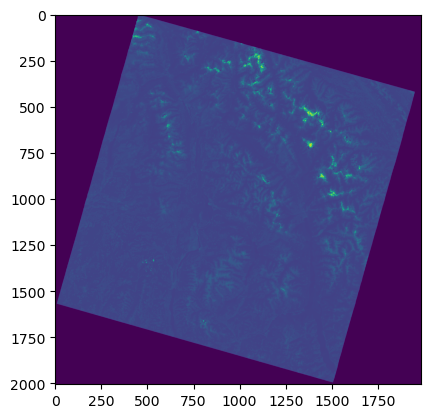

<Axes: >

In [5]:
aws_session = AWSSession(boto3_session, requester_pays=True)
file_s3 = 's3://usgs-landsat/collection02/level-2/standard/oli-tirs/2015/044/025/LC08_L2SP_044025_20150812_20200908_02_T1/LC08_L2SP_044025_20150812_20200908_02_T1_SR_B2.TIF'
with rio.Env(aws_session):
    with rio.open(file_s3, 'r') as src:
        # list of overviews
        oviews = src.overviews(1)
        # get second item from list to retrieve a thumbnail
        oview = oviews[1]
        # read first band of file and set shape of new output array
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
# now display the thumbnail
show(thumbnail)

You may adjust the expiration time of the AWS credentials generated by `maap.aws.requester_pays_credentials()`: 

In [ ]:
# Credential expiration time in seconds (defaults to 12 hours)
maap.aws.requester_pays_credentials(expiration=3600)